In [1]:
import tensorflow          as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot   as plt
import numpy               as np
import seaborn             as sns

from PIL                import Image
from google.colab       import output

from tensorflow         import keras
from keras.layers       import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Flatten, Lambda, Reshape, Cropping2D
from keras.models       import Model
from keras.applications import VGG16

from keras import backend as K

from keras.applications.vgg16 import preprocess_input

### Data preprocessing

In [2]:
def process_img(img, label):
    return decode_img(img), label

def decode_img(image):
    image = tf.image.encode_jpeg(image)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    return image

def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

### Assignment 1: Traditional Autoencoder

- Install tensorflow-datasets 
- import the colorectal_histology dataset
       images = tfds.load(name='colorectal_histology',split='train',as_supervised=True)
       images = images.batch(16)
       images = images.map(lambda img,lab: (tf.image.convert_image_dtype(img, dtype=tf.float32),lab))
       images = images.map(lambda img,lab: (img,img))
- Build an autoencoder
- Data is 150x150, use tf.keras.layers.experimental.preprocessing.Resizing to resize
- Remember how to build an image decoder from Lab 7
- Use MSE as loss
- Train the autoencoder

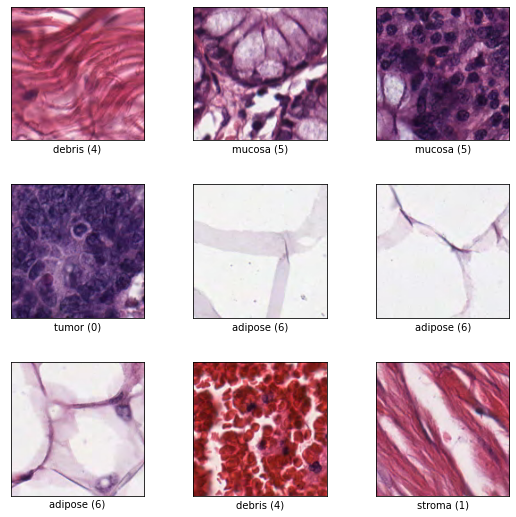

In [21]:
images, info = tfds.load(name='colorectal_histology', split='train', as_supervised=True, with_info=True)
output.clear()

fig = tfds.show_examples(images, info)

HEIGHT = 28
WIDTH  = 28

images = images.map(process_img)
images = images.map(normalize_img)

images = images.batch(16)
images = images.map(lambda img, lab: (tf.image.convert_image_dtype(img, dtype=tf.float32), lab))
images = images.map(lambda img, lab: (img, img))

In [115]:
class Autoencoder():

  def __init__(self, input_img):

    self.model = self.build_autoencoder(input_img)

  def build_autoencoder(self, input_img):

    input = Input(shape=input_img)  

    # Encoding #

    # Conv1 #
    x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')(input)
    x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

    # Conv2 #
    x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size = (2, 2), padding='same')(x) 

    # Conv 3 #
    x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

    # Decoding #

    # DeConv1
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)

    # DeConv2
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    # Deconv3
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = tf.keras.Model(input, decoded)
    return model

In [116]:
input_img = (28,28,3)

autoencoder = Autoencoder(input_img)
autoencoder.model.compile(optimizer = "adam", loss = tf.keras.losses.MeanSquaredError())

autoencoder.model.fit(images,
                epochs=15,
                batch_size=16,
                shuffle=True)

Epoch 1/15
313/313 [==============================] - 7s 20ms/step - loss: 0.0465
Epoch 2/15
313/313 [==============================] - 6s 20ms/step - loss: 0.0281
Epoch 3/15
313/313 [==============================] - 6s 19ms/step - loss: 0.0271
Epoch 4/15
313/313 [==============================] - 6s 20ms/step - loss: 0.0264
Epoch 5/15
313/313 [==============================] - 6s 20ms/step - loss: 0.0260
Epoch 6/15
313/313 [==============================] - 6s 20ms/step - loss: 0.0257
Epoch 7/15
313/313 [==============================] - 6s 20ms/step - loss: 0.0255
Epoch 8/15
313/313 [==============================] - 6s 20ms/step - loss: 0.0253
Epoch 9/15
313/313 [==============================] - 6s 20ms/step - loss: 0.0252
Epoch 10/15
313/313 [==============================] - 6s 19ms/step - loss: 0.0251
Epoch 11/15
313/313 [==============================] - 6s 20ms/step - loss: 0.0250
Epoch 12/15
313/313 [==============================] - 6s 20ms/step - loss: 0.0249
Epoch 13/15
3

### Assignment 2: Autoencoder with perceptual loss

- Instead of using just MSE, initialize a VGG16 model pretrained on imagenet using
       tf.keras.applications.VGG16
- Optimise the sum of the previous loss and a small contribution (0.1) from the MSE in the feature space of VGG16 as the new loss (tf.keras.applications.vgg16.preprocess_input requires data in the [0,255] range)
- Compare the results

In [119]:
images, info = tfds.load(name='colorectal_histology', split='train', as_supervised=True, with_info=True)
output.clear()

HEIGHT = 148
WIDTH  = 148

images = images.map(process_img)
images = images.map(normalize_img)

images = images.batch(16)
images = images.map(lambda img, lab: (tf.image.convert_image_dtype(img, dtype=tf.float32), lab))
images = images.map(lambda img, lab: (img, img))

In [117]:
class PerceptualLossAutoencoder(Model):

  def __init__(self, input_img):
    
    super(PerceptualLossAutoencoder, self).__init__()

    self.model      = self.build_autoencoder(input_img)
    self.loss_model = self.build_loss_model(input_img)
    self.optimizer  = keras.optimizers.Adam(1e-3)

  def build_autoencoder(self, input_img):
    # Encoding #

    # Conv1 #
    input_layer = Input(shape=input_img)  
    conv1       = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')
    pool1       = MaxPooling2D(pool_size = (2, 2), padding='same')

    # Conv2 #
    conv2       = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')
    pool2       = MaxPooling2D(pool_size = (2, 2), padding='same') 

    # Conv 3 #
    conv3       = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')
    encoded     = MaxPooling2D(pool_size = (2, 2), padding='same')

    # Decoding #

    # DeConv1
    deconv1     = Conv2D(8, (3, 3), activation='relu', padding='same')
    upsampling1 = UpSampling2D((2, 2))

    # DeConv2
    deconv2     = Conv2D(8, (3, 3), activation='relu', padding='same')
    upsampling2 = UpSampling2D((2, 2))

    # Deconv3
    deconv3     = Conv2D(16, (3, 3), activation='relu')
    upsampling3 = UpSampling2D((2, 2))
    out         = Conv2D(3, (3, 3), activation='sigmoid', padding='same')

    return keras.Sequential([
      input_layer,
      conv1,
      pool1,
      conv2,
      pool2,
      conv3,
      encoded,
      deconv1,
      upsampling1,
      deconv2,
      upsampling2,
      deconv3,
      upsampling3,
      out
      ])

  def build_loss_model(self, input_img):
    loss_model = VGG16(include_top = False, weights = "imagenet", input_shape = input_img)

    loss_model.trainable = False

    for layer in loss_model.layers:
      layer.trainable = False

    return loss_model

  def get_loss(self, batch):

    X = batch[0]
    y = batch[1]

    decoded_images = self.model(X)

    if self.save_image == True:

      self.saved_images[self.epoch] = decoded_images[0]
      self.save_image = False
    
    model_loss      = self.get_mse_loss       (y, decoded_images)
    perceptual_loss = self.get_perceptual_loss(y, decoded_images)

    #print(f"Model loss: {model_loss}")
    #print(f"Perceptual loss: {perceptual_loss}")
    #print("---")

    return model_loss + 0.1 * perceptual_loss

  def get_mse_loss(self, y_true, y_pred):
    return np.mean(keras.losses.MSE(y_true, y_pred))

  def get_perceptual_loss(self, y_true, y_pred):

    y_true = preprocess_input(y_true * 255)
    y_pred = preprocess_input(y_pred * 255)

    return K.mean(K.square(self.loss_model(y_true) - self.loss_model(y_pred)))

  def train_step(self, epoch, batch):
    
    with tf.GradientTape() as tape:
      
      tape.watch(self.model.trainable_variables)

      loss = self.get_loss(batch)
      #print(float(loss))

      self.loss_values[epoch + 1].append(loss)
      
      gradient = tape.gradient(loss, self.model.trainable_variables)
    
    self.optimizer.apply_gradients(zip(gradient, self.model.variables))

  def call(self, dataset, epochs): # dataset = (images, images). It contains images and labels (so, the same images :) )

    self.loss_values  = {}
    self.saved_images = {}

    for epoch in range(epochs):
      
      self.epoch = epoch + 1
      
      print("EPOCH: " + str(epoch+1))
      batch_number = 1
      self.save_image = True

      self.loss_values[epoch + 1] = []

      for batch in dataset:

        #percentage = str(round(batch_number * 100 / len(dataset),2)) + "%"
        #print(percentage, end="\t")

        batch = tf.cast(batch, tf.dtypes.float32)
        self.train_step(epoch, batch)

        #batch_number += 1
      
      print(f"Loss: {float(np.mean(self.loss_values[epoch+1]))}")

      #output.clear()    

In [ ]:
input_img = (HEIGHT,WIDTH,3)
EPOCHS = 50

autoencoder = PerceptualLossAutoencoder(input_img)

autoencoder(images, EPOCHS)

EPOCH 2, Loss: 3.584606885910034


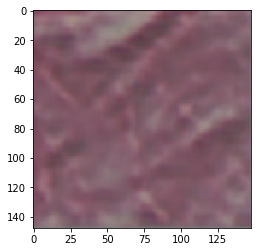

EPOCH 6, Loss: 2.9847166538238525


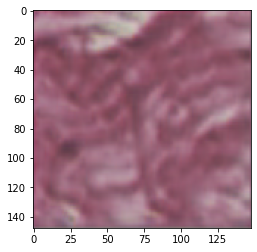

EPOCH 10, Loss: 2.7763469219207764


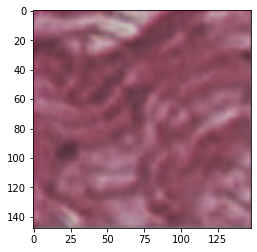

EPOCH 14, Loss: 2.6499431133270264


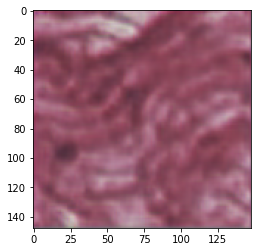

EPOCH 18, Loss: 2.569523811340332


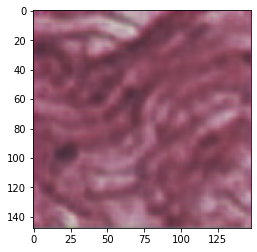

EPOCH 22, Loss: 2.516226291656494


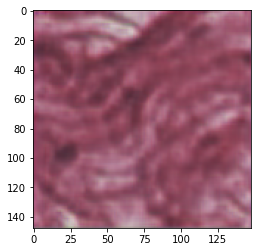

EPOCH 26, Loss: 2.4731409549713135


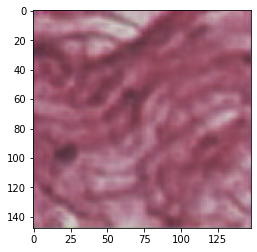

EPOCH 30, Loss: 2.434339761734009


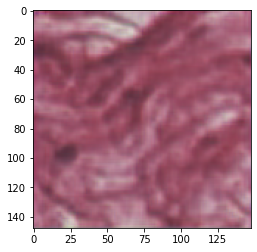

EPOCH 34, Loss: 2.4134480953216553


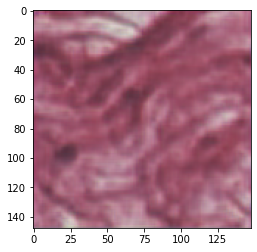

EPOCH 38, Loss: 2.3845508098602295


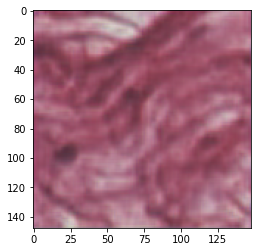

EPOCH 42, Loss: 2.3604795932769775


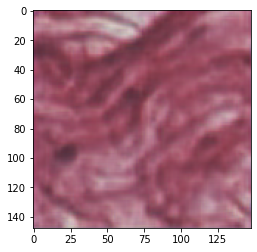

EPOCH 46, Loss: 2.343294858932495


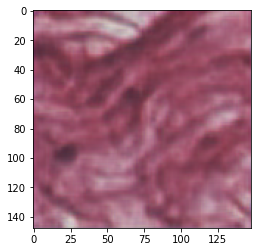

EPOCH 50, Loss: 2.3333451747894287


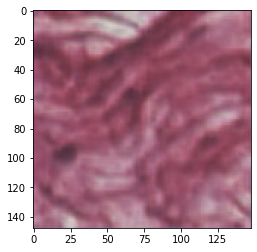

In [ ]:
for epoch in range(2, EPOCHS + 1, 4):
  print(f"EPOCH {epoch}, Loss: {float(np.mean(autoencoder.loss_values[epoch]))}")
  #sns.regplot(x = [i for i in range(len(autoencoder.loss_values[epoch]))], y = autoencoder.loss_values[epoch], scatter_kws={'s':3})
  #plt.show(block=True)
  plt.imshow(autoencoder.saved_images[epoch])
  plt.show(block=True)

### Assignment 3: Variational Autoencoder
- Use 2 fully connected layers for the latent space, one for the mean and one for the variance
- Use the reparametrization trick to sample from the distribution
- Feed the sampled vector to the decoder
- loss = reconstruction loss + β KLD (formula in slide 7)
- What happens if β is too high?

In [30]:
images, info = tfds.load(name='colorectal_histology', split='train', as_supervised=True, with_info=True)
output.clear()

HEIGHT = 28
WIDTH  = 28

images = images.map(process_img)
images = images.map(normalize_img)

images = images.batch(16)
images = images.map(lambda img, lab: (tf.image.convert_image_dtype(img, dtype=tf.float32), lab))
images = images.map(lambda img, lab: (img, img))

In [103]:
beta       = 0.5
input_img  = (HEIGHT, WIDTH, 3)
latent_dim = 2 # mu, sigma
EPOCHS     = 30

encoder  = Encoder(input_img, latent_dim)
decoder  = Decoder(encoder.conv_shape)

vae = VAE(encoder.model, decoder.model, beta)

vae.compile(optimizer = keras.optimizers.Adam())

vae.fit(images, epochs = EPOCHS, batch_size = 16)

Epoch 1/30
313/313 [==============================] - 7s 20ms/step - loss: 454.4531 - reconstruction_loss: 450.6862 - kl_loss: 3.7668
Epoch 2/30
313/313 [==============================] - 7s 21ms/step - loss: 431.3391 - reconstruction_loss: 428.6033 - kl_loss: 2.7358
Epoch 3/30
313/313 [==============================] - 6s 21ms/step - loss: 429.9396 - reconstruction_loss: 427.6680 - kl_loss: 2.2716
Epoch 4/30
313/313 [==============================] - 7s 21ms/step - loss: 429.5969 - reconstruction_loss: 427.4955 - kl_loss: 2.1014
Epoch 5/30
313/313 [==============================] - 7s 21ms/step - loss: 429.3999 - reconstruction_loss: 427.3991 - kl_loss: 2.0008
Epoch 6/30
313/313 [==============================] - 6s 21ms/step - loss: 429.2511 - reconstruction_loss: 427.3299 - kl_loss: 1.9212
Epoch 7/30
313/313 [==============================] - 6s 21ms/step - loss: 428.9906 - reconstruction_loss: 427.1229 - kl_loss: 1.8676
Epoch 8/30
313/313 [==============================] - 7s 21ms/

In [114]:
class Encoder():

  def __init__(self, input_img_shape, latent_dim = 2):

    self.input_img_shape = input_img_shape
    self.latent_dim      = latent_dim

    # Encoding #

    encoder_input = Input(shape = self.input_img_shape) 

    # Conv1 #
    conv2d_1 = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_input)

    # Conv2 #
    conv2d_2 = Conv2D(64, 3, activation="relu", strides=2, padding="same")(conv2d_1)

    # Conv 3 #
    self.conv_shape = K.int_shape(conv2d_2)

    flatten = Flatten()(conv2d_2)
    dense   = Dense(16, activation = "relu")(flatten)

    z_mu    = Dense(latent_dim)(dense) # [mu0, mu1]
    z_sigma = Dense(latent_dim)(dense) # [sd0, sd1]

    z = Sampling()([z_mu, z_sigma])

    self.model = Model(encoder_input, [z, z_mu, z_sigma])

class Sampling(keras.layers.Layer):

  def call(self, inputs):
    z_mean, z_log_var = inputs

    batch = tf.shape(z_mean)[0]
    dim   = tf.shape(z_mean)[1]

    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Decoder():

  def __init__(self, conv_shape, latent_dim = 2):

    self.conv_shape = conv_shape
    self.latent_dim = latent_dim

    # Decoding #

    decoder_input = Input(shape=(latent_dim, ))

    dense = Dense(self.conv_shape[1]*self.conv_shape[2]*self.conv_shape[3], activation="relu")(decoder_input)
    reshape = Reshape((self.conv_shape[1], self.conv_shape[2], self.conv_shape[3]))(dense)

    # DeConv1
    deconv2d_1 = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(reshape)

    # DeConv2 
    deconv2d_2 = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(deconv2d_1)

    # DeConv3
    out = Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(deconv2d_2)

    self.model = Model(decoder_input, out)

class VAE(tf.keras.models.Model):

  def __init__(self, encoder, decoder, beta):

    super(VAE, self).__init__()

    self.beta    = beta
    self.encoder = encoder
    self.decoder = decoder
    
  def train_step(self, data):

    if isinstance(data, tuple):
        data = data[0]

    data = tf.cast(data, tf.dtypes.float32)

    with tf.GradientTape() as tape:
      
      z, z_mu, z_sigma = self.encoder(data)
      reconstructed    = self.decoder(z)

      reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstructed))

      reconstruction_loss *= 28 * 28

      kl_loss = -0.5 * tf.reduce_mean(1 + z_sigma - tf.square(z_mu) - tf.exp(z_sigma))

      loss = reconstruction_loss + self.beta * kl_loss
      
    gradients = tape.gradient(loss, self.trainable_weights)
    
    self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

    return {
      "loss":                loss,
      "reconstruction_loss": reconstruction_loss,
      "kl_loss":             kl_loss,
    }